In [2]:
] activate ..

  Activating environment at `e:\Pythonfiles\JP\ML\Project.toml`


# Chapter 1. Universal Differential Equations

In this Chapter, I will use the following model:
$$ \begin{aligned}
& \frac{\rm{d}S}{\rm{dt}} = \Lambda -\beta S I - d S,\\
&\frac{\rm{d}I}{\rm{dt}} = \beta S I - (d+\gamma) S
\end{aligned}$$
to generate data with noise, and use the following universal differential equation to learn the model.
$$ \begin{aligned}
& \frac{\rm{d}S}{\rm{dt}} = \Lambda -NN(S,I) - d S,\\
&\frac{\rm{d}I}{\rm{dt}} = NN(S,I) - (d+\gamma) S,
\end{aligned}.$$
where $NN$ is a deep neural network. 

## 1.1 Generate the data with noise

loading Packages needed in Julia

In [3]:
using DifferentialEquations
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots

Define SIR Model. 

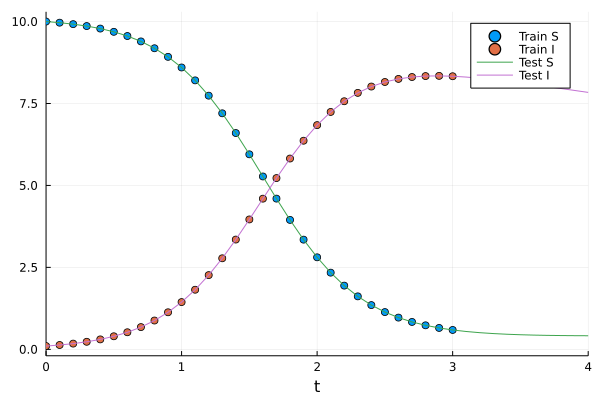

In [ ]:
function SIR(du,u,p,t)
    Λ, d, β, γ = p
    S, I = u
    du[1] = Λ - β*S*I - d*S
    du[2] = β*S*I - (d+γ)*I
end
u_0 = [10.0, 0.1]
p_data = [1,0.1,0.3,0.1]
tspan_data = (0.0, 3.0)
prob_data = ODEProblem(SIR,u_0,tspan_data,p_data)
data_solve = solve(prob_data, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
data_withoutnois = Array(data_solve)
data = data_withoutnois #+ Float32(2e-1)*randn(eltype(data_withoutnois), size(data_withoutnois))
scatter(data_solve.t, data[1,:],label = "Train S")
scatter!(data_solve.t, data[2,:],label = "Train I")
tspan_predict = (0.0, 4.0)
prob_predict = ODEProblem(SIR,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
plot!(test_data, label=["Test S" "Test I"])


## 1.2 Train the universal SIR model

In this part, I will use the universal differential equation to train the force of infection.

### 1.2.1 Define the universal SIR model

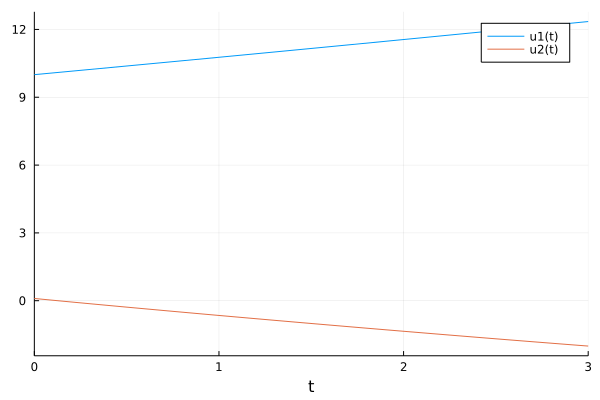

In [5]:
ann_node = FastChain(FastDense(2, 5, tanh), FastDense(5,5, tanh),FastDense(5, 1))
p = Float64.(initial_params(ann_node))
p_know = [1.0,0.1,0.1]
function SIR_nn(du,u,p,t)
    Λ, d, γ = p_know
    S, I = u
    du[1] = Λ - ann_node([S,I],p)[1]- d*S
    du[2] = ann_node([S,I],p)[1] - (d+γ)*I
    [du[1],du[2]]
end
prob_nn = ODEProblem(SIR_nn, u_0, tspan_data, p)
s = concrete_solve(prob_nn, Tsit5(), u_0, p, saveat = data_solve.t)
plot(s)




### 1.2.2 Train the universal SIR model

In [6]:
function train(θ)
    Array(concrete_solve(prob_nn, Vern7(), u_0, θ, saveat = 0.1,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end

function loss(θ)
    pred = train(θ)
    sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end

loss(p)

const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end

res2_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.02), cb=callback, maxiters = 2000)




86.97112989517423
54.28501927265002
30.861244036855933
15.646949745216883
7.423423022461483
3.9922763084400477
2.531339935132947
1.8520403655646707
1.455474305988732
1.1267476832683458
0.702469643551658
0.6169109973911239
0.5829826273927983
0.5845961976991713
0.5597647410344845
0.545749082408899
0.5358960320513916
0.5270850480473037
0.5183511401993735
0.6286279623787856
0.5321150496165741
0.5141556935887195
0.5040013102614473
0.49509728458819957
0.48567446723564545
0.5076496028730862
0.49670256453467804
0.47866981439016126
0.46644425384093524
0.4529005955763762
0.8148486364502117
0.4685236697503684
0.438487508791469
0.4178974597835178
0.3965221121913057
0.8024570032436661
0.41805240951935574
0.3781579819451413
0.34958856373666014
0.3155605009291722


LoadError: UndefVarError: res1_node not defined

In [7]:
res2_node = DiffEqFlux.sciml_train(loss, res2_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 1000)

0.008304629001957454
0.00163775534764481
0.0002576927456781189
0.0001326049345448296
4.893625493057836e-5
3.351120240941049e-5
2.133756764651488e-5
1.658561356843314e-5
9.577032752874279e-6
7.254762504370488e-6
6.927845504985277e-6
6.663040783122388e-6
5.703938875148808e-6
3.6530572097524836e-6
2.8490050623203946e-6
2.0957562630920074e-6
1.512968272551534e-6
1.28456177907608e-6
1.0261076548479709e-6
8.227772720920721e-7


u: 51-element Vector{Float64}:
 -0.1819781636302178
 -0.20308829308668622
 -0.03456991449927656
 -0.6321342905445696
  0.026851585544527514
  0.08619746407295309
 -0.31422997987440515
  0.2993849581246007
 -0.09544095351156756
  1.3025648151660694
 -0.04622084530249706
 -0.21157232425798175
  0.3689481320995332
  ⋮
  0.32322523239858436
  1.2057455454449464
  0.23654057544243728
  1.0208154637806235
  0.11070050274981504
 -0.1534920201129412
 -2.8246658909007887
 -1.7963377459599017
 -4.582599333996811
  1.8830458018649912
 -1.7655160477828367
 -0.22401038692605524

### 1.2.3 Plot the training results

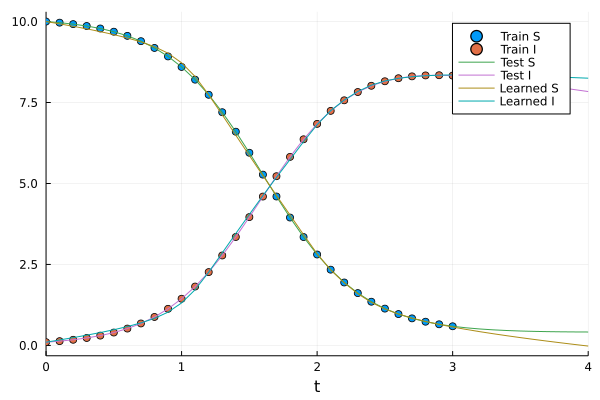

In [ ]:
scatter(data_solve.t, data[1,:],label = "Train S")
scatter!(data_solve.t, data[2,:],label = "Train I")
plot!(test_data, label=["Test S" "Test I"])


prob_nn2 = ODEProblem(SIR_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn,label=["Learned S" "Learned I"])


# Plot the losses

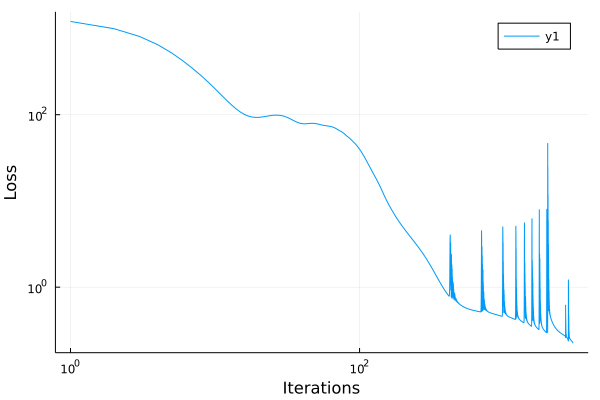

In [ ]:
plot(losses, yaxis = :log, xaxis = :log, xlabel = "Iterations", ylabel = "Loss")

## 1.3 Summarization

It can be seen from the learning results that universal SIR can fit the data well but fails in prediction. The reason behind the failure may comes from little data (48 paramters but 40 data points) and overfitting. Future improvements:
* Tricks on choosing hyperparameters. 
  * Hidden layers number
  * Learning rates
  * Maximum Iteration
* Trying other numerical methods.
  * Methods on solving universal differential equations. Tits5(), Vern7(), and so on.
  * Methods on autodifferentiation.
  * Methods on optimization. Adam(), BFGS(), and so on.
* Other tricks such as regulization, weights initializers, dropout, and so on.

# Chapter 2. Neural ordinary differential equation. Using SIR model as a layer.

In this chapter, I will show how differential equations can be a layer of NN network.

## 2.1 Define SIR model

In [ ]:
function SIR!(du,u,p,t)
    Λ, d, β, γ = p
    S, I = u
    du[1] = Λ - β*S*I - d*S
    du[2] = β*S*I - (d+γ)*I
end
u_0 = [10.0, 0.1]
p_data = [1,0.1,0.3,0.1]
tspan_data = (0.0, 2.0)
function solution_SIR(p)
    prob_data = ODEProblem(SIR!,u_0,tspan_data,p)
    data_solve = solve(prob_data, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
end
println(solution_SIR(p_data)[:,end]')

[2.8075003984547564 6.840627250127716]


## 2.2 Using SIR model as a layer

In [ ]:
using DiffEqFlux, OrdinaryDiffEq, Flux, Printf
using Flux: flatten
using Flux: params

function f(x)
    2*x+1
end
#coupled_model = Chain(Dense(2, 21, relu), p -> solution_SIR(p)[1,:], Dense(21,5, tanh),Dense(5, 1))
coupled_model = Chain(Dense(2, 21, relu), p -> solution_SIR(p)[1,:], x -> x[2:end], Dense(20,5, tanh),Dense(5, 1))
#coupled_model = FastChain(FastDense(2, 2, relu),x -> f.(x), p -> solution_SIR(p)[:,end]', FastDense(2,5, tanh),FastDense(5, 1))
#coupled_model = Chain(Dense(2, 2, relu),x -> f.(x), p -> solution_SIR(p)[:,end], Dense(2,5, tanh),Dense(5, 1))

u_1 = [5, 0.1]
p_init = Float64.(initial_params(coupled_model))
println(coupled_model(u_1))



[-1.7888719044700214]


## 2.3. Summarization

SIR model can be a layer of NN, but one need to deeply understand how different layers interact with each others, especially when the dimension is high and vectors become tensors.
The layer can be any function, any tensor handling methods (such as reshape), any deep learning method layer, any basis (such as Fourier basis),
any deep learning tricks (sampling, dropout). 

The tricks here should be:
* Choose right kind of layers.
* Choose right differential equations output.
* Others tricks I haven't known.